In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

In [28]:
df = pd.read_csv("data/data.csv")
df['text'] = df['text'].astype(str)

In [29]:
# Загрузка модели
model = SentenceTransformer('cointegrated/rubert-tiny2')

# Генерация эмбеддингов
embeddings = model.encode(df['text'].tolist(), convert_to_tensor=True)

In [30]:
# Маппинги
id_to_idx = {row['id']: idx for idx, row in df.iterrows()}
idx_to_id = {v: k for k, v in id_to_idx.items()}
group_id_by_idx = df['group_id'].tolist()

In [ ]:
# Все истинные пары по group_id в оригинальном датасете
true_pairs = set()
for group_id, group_df in df.groupby('group_id'):
    ids = list(group_df['id'])
    true_pairs.update({tuple(sorted(pair)) for pair in combinations(ids, 2)})

In [32]:
def duplicates(threshold):
    """Поиск смысловых дубликатов"""
    predicted_duplicates = []

    for i, j in combinations(range(len(df)), 2):
        sim = cosine_similarity(
            embeddings[i].unsqueeze(0).numpy(),
            embeddings[j].unsqueeze(0).numpy()
        )[0][0]

        if sim >= threshold:
            predicted_duplicates.append({
                'id_1': df.iloc[i]['id'],
                'id_2': df.iloc[j]['id'],
                'group_id_1': df.iloc[i]['group_id'],
                'group_id_2': df.iloc[j]['group_id'],
                'similarity': sim
            })

    # Создание DataFrame с предсказанными дубликатами
    return pd.DataFrame(predicted_duplicates)

In [40]:
def metrics(pred_df):
    """Подсчитываем метрики accuracy/recall"""
    predicted_pairs = set(tuple(sorted((row['id_1'], row['id_2']))) for _, row in pred_df.iterrows())
    true_positive_pairs = predicted_pairs.intersection(true_pairs)
    false_negative_pairs = true_pairs - predicted_pairs

    # Вычисление accuracy и recall
    true_positives = pred_df[pred_df['group_id_1'] == pred_df['group_id_2']]
    false_positives = pred_df[pred_df['group_id_1'] != pred_df['group_id_2']]

    # Метрики
    accuracy = len(true_positives) / len(pred_df) if len(pred_df) > 0 else 1.0
    recall = len(true_positive_pairs) / len(true_pairs) if len(true_pairs) > 0 else 1.0

    # print(f'Accuracy: {accuracy:.4f}')
    # print(f'Recall: {recall:.4f}')
    # print(f'False positives: {len(false_positives)}')
    # print(f'False negatives: {len(false_negative_pairs)}')
    return accuracy, recall

In [41]:
accuracies = []
recalls = []
thresholds = np.arange(0.8, 0.98, 0.01)

for threshold in thresholds:
    print(f'Порог: {threshold}')
    pred_df = duplicates(threshold)
    accuracy, recall = metrics(pred_df)
    accuracies.append(accuracy)
    recalls.append(recall)

print(accuracies)
print(recalls)

Порог: 0.8
Порог: 0.81
Порог: 0.8200000000000001
Порог: 0.8300000000000001
Порог: 0.8400000000000001
Порог: 0.8500000000000001
Порог: 0.8600000000000001
Порог: 0.8700000000000001
Порог: 0.8800000000000001
Порог: 0.8900000000000001
Порог: 0.9000000000000001
Порог: 0.9100000000000001
Порог: 0.9200000000000002
Порог: 0.9300000000000002
Порог: 0.9400000000000002
Порог: 0.9500000000000002
Порог: 0.9600000000000002
Порог: 0.9700000000000002
[0.4440425959413301, 0.5787671232876712, 0.7005450464892594, 0.8094170403587444, 0.882864238410596, 0.9311417147934251, 0.9631901840490797, 0.9801783944499505, 0.9936941671045717, 0.9988706945228685, 0.9993722536095417, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.9697235629662132, 0.9640193067134708, 0.958753839403247, 0.9504168494953927, 0.9359368143922773, 0.9197016235190874, 0.8955682316805617, 0.8679245283018868, 0.8297498903027644, 0.7762176393154893, 0.6985519964896885, 0.6072838964458096, 0.491882404563405, 0.3760421237384818, 0.258446687143484, 0.151382

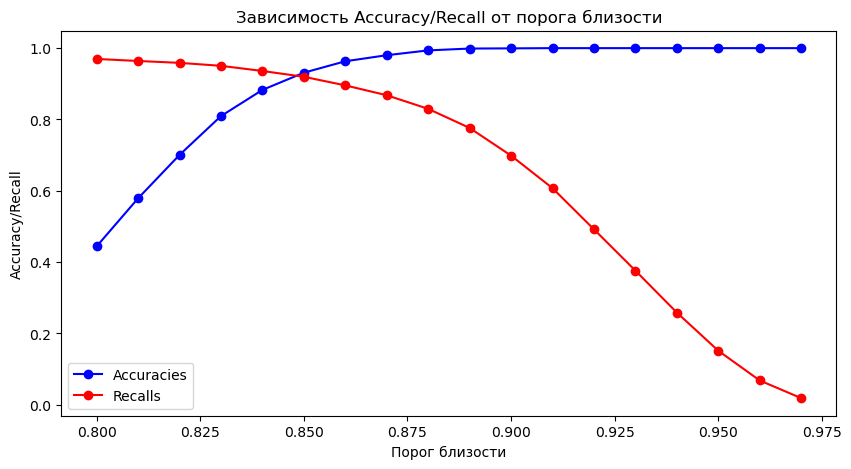

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, accuracies, marker="o", label="Accuracies", color="blue")
plt.plot(thresholds, recalls, marker="o", label="Recalls", color="red")
plt.xlabel("Порог близости")
plt.ylabel("Accuracy/Recall")
plt.title("Зависимость Accuracy/Recall от порога близости")
plt.legend()
plt.show()